In [824]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

AUTOTUNE = tf.data.AUTOTUNE

RES_HEIGHT = 24
RES_WIDTH = 32
NUM_CLASS = 1
N_BATCH = 3
N_EPOCH = 200
LR = 0.0002

In [825]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2024-04-03 14:21:33.980183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 22455 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2024-04-03 14:21:33.980583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:1 with 22455 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6
2024-04-03 14:21:33.980963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:2 with 22455 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6
2024-04-03 14:21:33.981335: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:3 with 22455 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6
2024-04-03 14:21:33.981704: I tensorflow/core/common_runtime/gpu/gpu_dev

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1230032100078311347
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 23546626048
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5761315202815363124
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 23546626048
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12389437297334182765
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6"
 xla_global_id: 2144165316,
 name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 23546626048
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11738522174187023644
 physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6"
 xla_global

### 현제 바운딩박스는 xmin, ymin, xmax, ymax 

In [826]:
import numpy as np

datasets = np.load('dataset/ObjectDetection.npz', allow_pickle=True)
images, numbers, bboxes = datasets['images'], datasets['numbers'], datasets['bboxes']

max_label_length = 4
labels = []
for num in numbers:
    cls = [1] * num if num != 0 else [0]
    cls += [0] * (max_label_length - len(cls))
    labels.append(cls)

# labels = np.array(labels)

# non_zero_indices = np.where(numbers != 0)[0]
non_zero_indices = np.where(numbers > 3)[0]

# numbers가 0이 아닌 항목만 유지
images_filtered = images[non_zero_indices]
bboxes_filtered = bboxes[non_zero_indices]
labels_filtered = np.array(labels)[non_zero_indices]

print(images.shape, numbers.shape, bboxes.shape, len(labels))

print(images.max(), images.min())

dataset = {
    'images' : images_filtered[3],
    'bboxes' : bboxes_filtered[3],
    'class' : labels_filtered[3]
}

print(dataset['images'].shape)
print(dataset['bboxes'].shape)
print(len(dataset['class']))
print(dataset['class'])


(17820, 24, 32, 1) (17820,) (17820, 4, 4) 17820
255 0
(24, 32, 1)
(4, 4)
4
[1 1 1 1]


In [827]:
print(dataset['class'])

[1 1 1 1]


[[ 0  6  7 12]
 [ 0 15  7 21]
 [11 13 20 23]
 [26  3 32  8]]
240 0


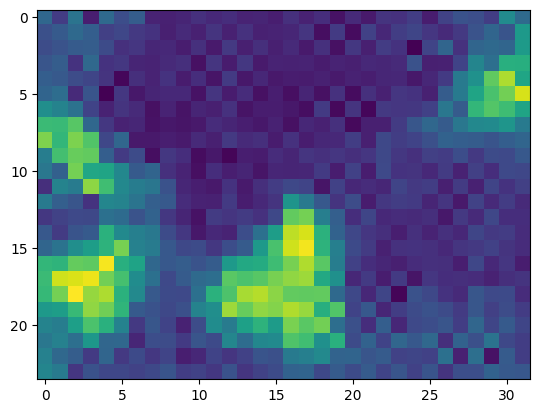

In [828]:
plt.imshow(dataset['images'])
print(dataset['bboxes'])
print(dataset['images'].max(), dataset['images'].min())

(24, 32, 1)
24
32


bbox:  tf.Tensor(
[[ 0  6  7 12]
 [ 0 15  7 21]
 [11 13 20 23]
 [26  3 32  8]], shape=(4, 4), dtype=int64)


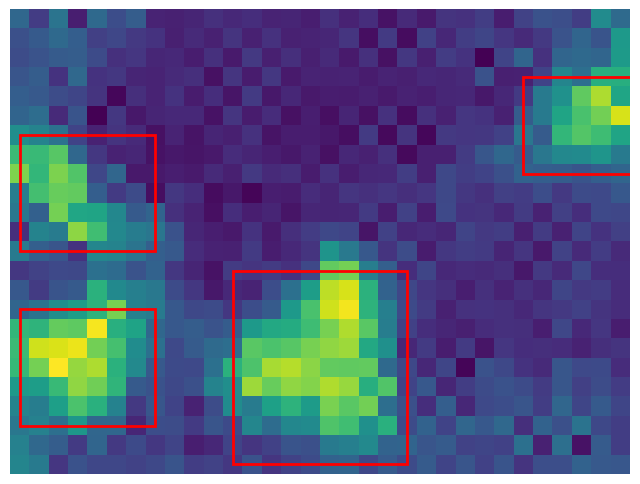

[1 1 1 1]


In [829]:
import matplotlib.pyplot as plt
import tensorflow as tf
images = dataset['images']
bboxes = dataset['bboxes']
cls = dataset['class']

boxes = bboxes
plt.figure(figsize = (8, 8))
plt.axis('off')
image = images
print(image.shape)
print(image.shape[0])
print(image.shape[1])
plt.imshow(image)
ax = plt.gca()
boxes = tf.stack([
	(boxes[:, 0] ), 
	(boxes[:, 1] ),
	(boxes[:, 2] ),
	(boxes[:, 3] )], axis = -1
)
print("bbox: ", boxes)
# 각 바운딩 박스에 대해 반복하여 그리기
for box in boxes:
    xmin, ymin, xmax, ymax = box 
    w, h = xmax - xmin, ymax - ymin
    patch = plt.Rectangle(
        [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
    )
    ax.add_patch(patch)
plt.show()
print(cls)

In [830]:
images.max(), images.min()

(240, 0)

In [831]:
import os
import random
import tensorflow as tf

IMG_SIZE_WIDTH = 32
IMG_SIZE_HEIGHT = 24
N_DATA = 1
N_TRAIN = 1

cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'test/tfrecord/')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
# tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

print("IMG_SIZE_WIDTH:  ", IMG_SIZE_WIDTH)
print("IMG_SIZE_HEIGHT: ", IMG_SIZE_HEIGHT)
print("N_DATA:          ", N_DATA)
print("N_TRAIN:         ", N_TRAIN)



shuffle_list = list(range(N_DATA))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]

cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'test/tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')

writer_train = tf.io.TFRecordWriter(tfr_train_dir)

IMG_SIZE_WIDTH:   32
IMG_SIZE_HEIGHT:  24
N_DATA:           1
N_TRAIN:          1


In [832]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def _float_feature(value):
    return tf.train.Feature(float_list = tf.train.FloatList(value = value))

def _int64_feature(value):
    return tf.train.Feature(int32_list = tf.train.Int64List(value = [value]))


def _bytes_feature_list(value_list):
    """value_list가 리스트일 때, 이를 serialize하여 bytes list로 변환하는 함수."""
    value_list = [tf.io.serialize_tensor(tf.constant(v)).numpy() for v in value_list]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value_list))


In [833]:
dataset['images'] = dataset['images'].reshape(1, 24, 32, 1)
dataset['bboxes'] = dataset['bboxes'].reshape(1, 4, 4)
dataset['class'] = np.array(dataset['class']).reshape(1, 4)
images = dataset['images']
bboxes = dataset['bboxes']
cls = dataset['class']
print(images.shape)
print(bboxes.shape)
print(cls.shape)


(1, 24, 32, 1)
(1, 4, 4)
(1, 4)


In [834]:
for idx in train_idx_list:
    bbox = bboxes[idx]
    xmin, ymin, xmax, ymax = bbox[:, 0] / RES_WIDTH, bbox[:, 1] / RES_HEIGHT, bbox[:, 2] / RES_WIDTH, bbox[:, 3] / RES_HEIGHT
    bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()

    image = images
    print(image.shape)
    print(bbox.shape)
    bimage = image.tobytes()

    number = numbers
    class_id = cls
    # print(len(cls))
    serialized_cls = tf.io.serialize_tensor(tf.constant(class_id)).numpy()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'bbox': _float_feature(bbox),
        'label': _bytes_feature(serialized_cls),
        # 'number': _int64_feature(number)
    }))
    writer_train.write(example.SerializeToString())
writer_train.close()


(1, 24, 32, 1)
(16,)


In [835]:
AUTOTUNE = tf.data.AUTOTUNE

N_BATCH = 1
# LR = 0.0005


def _parse_function(tfrecord_serialized):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'bbox': tf.io.VarLenFeature(tf.float32),  
        'label': tf.io.FixedLenFeature([], tf.string),
        # 'number': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [1, RES_HEIGHT, RES_WIDTH, 1])
    # image = image / tf.reduce_max(image)
    image = tf.cast(image, tf.float32) 
    # image = image.reshape(1, 24, 32, 1)
    # image = image / tf.reduce_max(image)

    bbox = tf.sparse.to_dense(parsed_features['bbox']) 
    bbox = tf.cast(bbox, tf.float32)
    # num_boxes = tf.shape(bbox)[0] // 4
    bbox = tf.reshape(bbox, [1, -1, 4])

    serialized_cls = parsed_features['label']
    label = tf.io.parse_tensor(serialized_cls, out_type=tf.int64)
    label = tf.cast(label, tf.int32)
    # number = tf.cast(parsed_features['number'], tf.int64)
    return image, bbox, label


train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)

In [836]:
for img, bbox, label in train_dataset:
    print(img.shape)
    print(bbox)
    print(label)

(1, 24, 32, 1)
tf.Tensor(
[[[0.         0.25       0.21875    0.5       ]
  [0.         0.625      0.21875    0.875     ]
  [0.34375    0.5416667  0.625      0.9583333 ]
  [0.8125     0.125      1.         0.33333334]]], shape=(1, 4, 4), dtype=float32)
tf.Tensor([[1 1 1 1]], shape=(1, 4), dtype=int32)


In [837]:
# q!

(24, 32, 1)
tf.Tensor(
[[0.         0.25       0.21875    0.5       ]
 [0.         0.625      0.21875    0.875     ]
 [0.34375    0.5416667  0.625      0.9583333 ]
 [0.8125     0.125      1.         0.33333334]], shape=(4, 4), dtype=float32)


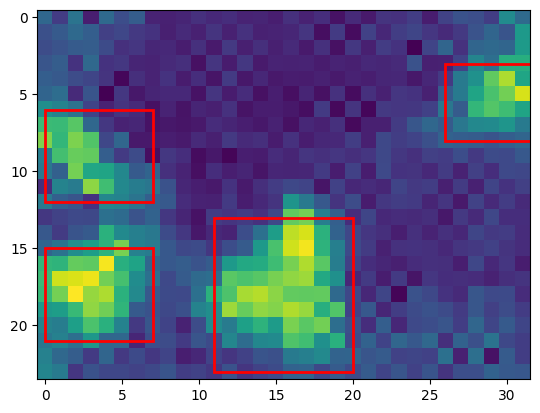

In [838]:
import matplotlib.pyplot as plt

idx = 0
for image, bbox, label in train_dataset:
    image = image[idx]
    bbox = bbox[idx]
    # label = label[idx]
    image = image.numpy()
    plt.imshow(image)
    ax = plt.gca()  
    print(image.shape)
    # print(label)
    print(bbox)
    boxes = tf.stack(
    	[
    	 bbox[:,0] * RES_WIDTH,
    	 bbox[:,1] * RES_HEIGHT,
    	 bbox[:,2] * RES_WIDTH,
    	 bbox[:,3] * RES_HEIGHT
    	], axis = -1
    )
    for box in boxes:
        xmin, ymin = box[:2]
        w, h = box[2:] - box[:2]
        patch = plt.Rectangle(
            [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)
    plt.show()

# [ 1  7 11 17]
#  [19  2 29 11]
#  [25  0 32  5]
#  [25  5 32 12]]


In [839]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1
    )

def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1
    )

In [840]:
def preprocess_data(image, gt_boxes, cls_ids):
    bbox = convert_to_xywh(gt_boxes)
    return image, bbox, cls_ids

In [841]:
for image, bbox, label in train_dataset:
    print(image.shape)
    print(bbox.shape)
    print(label.shape)

(1, 24, 32, 1)
(1, 4, 4)
(1, 4)


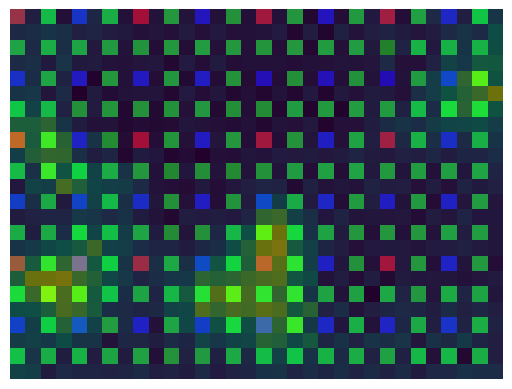

tf.Tensor(240.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


In [842]:
idx = 0
for image, bbox, label in train_dataset.take(1):
    anchor_img = np.zeros((*image.shape[:3], 3), dtype=np.uint8)
    anchor_img = anchor_img[idx]

    strides = [2, 4, 8]
    colors = {
        2: [0, 255, 0],  # 초록색
        4: [0, 0, 255],  # 파란색
        8: [255, 0, 0],   # 빨간색
    }

    for stride in strides:
        color = colors[stride]
        for y in range(0, anchor_img.shape[0], stride):
            for x in range(0, anchor_img.shape[1], stride):
                anchor_img[y, x, :] = color

    # 이미지 표시
    plt.imshow(image[idx], alpha=1)  
    plt.imshow(anchor_img, alpha=0.5) 
    plt.axis('off')
    plt.show()
    print(tf.reduce_max(image), tf.reduce_min(image))

(24, 32, 1)
tf.Tensor(
[[0.109375   0.375      0.21875    0.25      ]
 [0.109375   0.75       0.21875    0.25      ]
 [0.484375   0.75       0.28125    0.41666663]
 [0.90625    0.22916667 0.1875     0.20833334]], shape=(4, 4), dtype=float32)
tf.Tensor([1 1 1 1], shape=(4,), dtype=int32)
tf.Tensor(240.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
width:  32
height:  24
bbox:  tf.Tensor(
[[0.         0.25       0.21875    0.25      ]
 [0.         0.625      0.21875    0.25      ]
 [0.34375    0.5416667  0.28125    0.41666663]
 [0.8125     0.125      0.1875     0.20833334]], shape=(4, 4), dtype=float32)
tf.Tensor([0.      0.25    0.21875 0.25   ], shape=(4,), dtype=float32)
tf.Tensor([0.      0.625   0.21875 0.25   ], shape=(4,), dtype=float32)
tf.Tensor([0.34375    0.5416667  0.28125    0.41666663], shape=(4,), dtype=float32)
tf.Tensor([0.8125     0.125      0.1875     0.20833334], shape=(4,), dtype=float32)


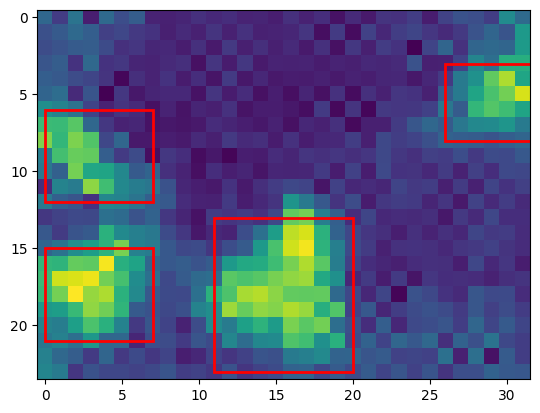

tf.Tensor([1 1 1 1], shape=(4,), dtype=int32)


In [843]:
idx = 0
for image, bbox, label in train_dataset:
    image, bbox, label = preprocess_data(image, bbox, label)
    img = image[idx]
    box = bbox[idx]
    label = label[idx]
    print(img.shape)
    print(box)
    print(label)
    print(tf.reduce_max(image), tf.reduce_min(image))
    # 이미지 시각화
    plt.imshow(img)
    ax = plt.gca()
    width = img.shape[1]
    height = img.shape[0]
    print("width: ", width)
    print("height: ", height)
    boxes = tf.stack(
        [
            (box[:, 0] - 0.5 * box[:, 2]),  # xmin = x_center - width/2
            (box[:, 1] - 0.5 * box[:, 3]),  # ymin = y_center - height/2
            box[:, 2],
            box[:, 3],
            
        ], axis=-1
    )
    print("bbox: ", boxes)
    # 각 바운딩 박스에 대해 반복하여 그리기
    for box in boxes:
        xmin, ymin, w, h = box
        print(box)
        patch = plt.Rectangle(
            [xmin * RES_WIDTH, ymin * RES_HEIGHT], w * RES_WIDTH, h * RES_HEIGHT, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)
    plt.show()
    print(label)
 

In [844]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.7, 1.0, 1.7]         # 이거랑 2268
        self.scales = [2** x for x in [0, 1/3, 2/3]] # 이걸로 바운딩박스 갯수 조절가능
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(0, 3)]
        self._areas = [x ** 2 for x in [5.8, 6.3, 7]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []

        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios: 
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis = -1), [1, 1, 2]
                )
                for scale in self.scales: 
                    anchor_dims.append(scale * dims) 
            anchor_dims_all.append(tf.stack(anchor_dims, axis = -2))
        return anchor_dims_all 
    
    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype = tf.float32) + 0.5
        ry = tf.range(feature_height, dtype = tf.float32) + 0.5

        centers = tf.stack(tf.meshgrid(rx, ry), axis = -1) * self._strides[level - 0] # stride시작점에 따라 바꿔야함 
        centers = tf.expand_dims(centers, axis = -2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])

        dims = tf.tile(
            self._anchor_dims[level - 0], [feature_height, feature_width, 1, 1] 
        )

        anchors = tf.concat([centers, dims], axis=-1) 

        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i), # 올림
                tf.math.ceil(image_width / 2 ** i),
                i
            )
            for i in range(0, 3)
        ]

        return tf.concat(anchors, axis=0)

Anchor 음수 값: False
tf.Tensor(
[[ 0.5        0.5        4.852628   6.932326 ]
 [ 0.5        0.5        6.113929   8.734183 ]
 [ 0.5        0.5        7.703067  11.004381 ]
 ...
 [30.        22.         9.1268835  5.368755 ]
 [30.        22.        11.499153   6.7642074]
 [30.        22.        14.488025   8.5223675]], shape=(9072, 4), dtype=float32)
(9072, 4)
(24, 32, 1)
[[0.84375    0.7083333  0.26147264 0.4980431 ]
 [0.390625   0.9375     0.15164463 0.2888469 ]
 [0.71875    0.375      0.32341364 0.2536578 ]
 [0.234375   0.4375     0.15164463 0.2888469 ]
 [0.671875   0.3125     0.23632109 0.18534987]
 [0.171875   0.8958333  0.37513635 0.29422456]
 [0.640625   0.47916666 0.2283607  0.3044809 ]
 [0.046875   0.39583334 0.2977459  0.23352619]
 [0.703125   0.0625     0.18125    0.24166666]
 [0.890625   0.35416666 0.15164463 0.2888469 ]
 [0.421875   0.8125     0.18125    0.24166666]
 [0.40625    0.04166667 0.196875   0.2625    ]
 [0.421875   0.22916667 0.2977459  0.23352619]
 [0.515625   0.5

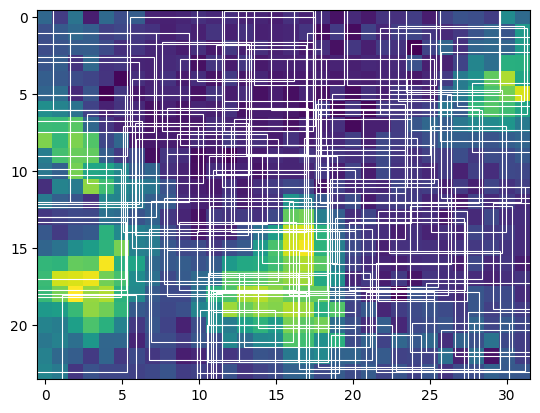

In [845]:
anchors = AnchorBox()
anchor = anchors.get_anchors(24, 32)

# 앵커 박스 정규화
xmin = anchor[:, 0] / RES_WIDTH
ymin = anchor[:, 1] / RES_HEIGHT
xmax = anchor[:, 2] / RES_WIDTH
ymax = anchor[:, 3] / RES_HEIGHT

# 정규화된 좌표를 스택으로 결합
normalized_anchor = tf.stack([xmin, ymin, xmax, ymax], axis=-1)

has_negative_values = tf.reduce_any(tf.less(anchor, 0))
print("Anchor 음수 값:", has_negative_values.numpy())

print(anchor)
print(anchor.shape)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes(data, num_samples):
    fig, ax = plt.subplots()

    plt.imshow(img)
    print(img.shape)
    data_np = data.numpy()

    if len(data) > num_samples:
        sampled_indices = np.random.choice(len(data), num_samples, replace=False)
        sample_data = data_np[sampled_indices]
    else : 
        sample_data = data_np
    print(sample_data)
    for center_x, center_y, width, height in sample_data:
        top_left_x = center_x - width / 2
        top_left_y = center_y - height / 2

        rect = patches.Rectangle((top_left_x * RES_WIDTH, top_left_y * RES_HEIGHT), width * RES_WIDTH, height * RES_HEIGHT, linewidth=0.8, edgecolor='white', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

draw_bounding_boxes(normalized_anchor, 100)


In [846]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    print(boxes1_corners.shape)
    print(boxes2_corners.shape)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])  
    
    intersection = tf.maximum(rd - lu, 0.0)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = (boxes1_corners[:, 2] - boxes1_corners[:, 0]) * (boxes1_corners[:, 3] - boxes1_corners[:, 1])
    boxes2_area = (boxes2_corners[:, 2] - boxes2_corners[:, 0]) * (boxes2_corners[:, 3] - boxes2_corners[:, 1])
    union_area = tf.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8)

    return intersection_area / union_area

In [847]:
GA = np.array([[50, 30, 70, 60], [50, 30, 70, 60]])  # 예: [xmin, ymin, xmax, ymax]
GT = np.array([[50, 30, 70, 60], [35, 45, 55, 75]])  # 예: [xmin, ymin, xmax, ymax]

print("GA.shape:", GA.shape)
print("GT.shape:", GT.shape)

GA_xywh = convert_to_xywh(GA)
print("GA (XYWH):", GA_xywh)

GT_xywh = convert_to_xywh(GT)
print("GT (XYWH):", GT_xywh)

iou = compute_iou(GA_xywh, GT_xywh)
print("IoU:", iou)
# GA = convert_to_corners(GA)
# print(GA)
# GT = convert_to_corners(GT)
# print(GT)

GA.shape: (2, 4)
GT.shape: (2, 4)
GA (XYWH): tf.Tensor(
[[60. 45. 20. 30.]
 [60. 45. 20. 30.]], shape=(2, 4), dtype=float64)
GT (XYWH): tf.Tensor(
[[60. 45. 20. 30.]
 [45. 60. 20. 30.]], shape=(2, 4), dtype=float64)
(2, 4)
(2, 4)
IoU: tf.Tensor(
[[1.         0.06666667]
 [1.         0.06666667]], shape=(2, 2), dtype=float64)


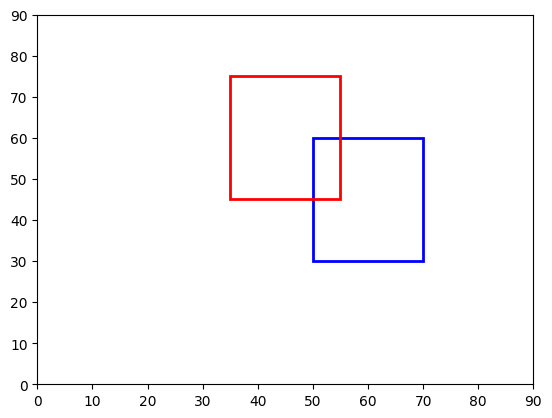

In [848]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 주어진 바운딩 박스 데이터
box1 = [50, 30, 70, 60]  # [x_min, y_min, x_max, y_max]
box2 = [35, 45, 55, 75]

# 그림 생성
fig, ax = plt.subplots()

# 첫 번째 바운딩 박스 추가
rect1 = patches.Rectangle((box1[0], box1[1]), box1[2] - box1[0], box1[3] - box1[1], 
                          linewidth=2, edgecolor='blue', facecolor='none')
ax.add_patch(rect1)

# 두 번째 바운딩 박스 추가
rect2 = patches.Rectangle((box2[0], box2[1]), box2[2] - box2[0], box2[3] - box2[1], 
                          linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect2)

# 축 범위 설정
ax.set_xlim(0, 90)
ax.set_ylim(0, 90)

# 그림 표시
plt.show()



In [849]:
def match_anchor_boxes(anchor_boxes, gt_boxes, match_iou = 0.5, ignore_iou = 0.4):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        print("iou_matrix:  ", iou_matrix)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        print("max_iou:  ", max_iou)


        matched_gt_idx = tf.argmax(iou_matrix, axis = 1)
        print("matched_gt_idx:  ", matched_gt_idx)
    
        positive_mask = tf.greater_equal(max_iou, match_iou)
        print("positive_mask:  ", positive_mask)
        negative_mask = tf.less(max_iou, ignore_iou)
        print("negative_mask:  ", negative_mask)

        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        print("ignore_mask:  ", ignore_mask)
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype = tf.float32),
            tf.cast(ignore_mask, dtype = tf.float32),
        )
        

In [850]:
anchor = np.array([
                    [27.,  18.5,  8.,   7.],
                    [18.5, 15.5, 11.,   7.],
                    [ 6.,   4.,   8.,   6.],
                    [ 0.,   0.,   0.,   0.],
                    [ 1., 1., 4.242641, 8.485281 ],
                    [ 1.,         1.,         5.3453927, 10.690784 ],
                    [ 1.,         1.,         6.7347727, 13.469543 ],
                    [30.,        22.,         9.899496,   4.949747 ]])

gt_boxes = np.array([[27.,  18.5,  8.,   7., ],
                     [18.5, 15.5, 11.,   7. ],
                     [ 6.,   4.,   8.,   6. ],
                     [ 0.,   0.,   0.,   0. ]])
# print(gt_boxes.shape)
a, b, c = match_anchor_boxes(tf.cast(anchor, tf.float32), tf.cast(gt_boxes, tf.float32))

(8, 4)
(4, 4)
iou_matrix:   tf.Tensor(
[[1.         0.03100775 0.         0.        ]
 [0.03100775 1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.06003535 0.        ]
 [0.         0.         0.09293901 0.        ]
 [0.         0.         0.11408175 0.        ]
 [0.16311106 0.         0.         0.        ]], shape=(8, 4), dtype=float32)
max_iou:   tf.Tensor(
[1.         1.         1.         0.         0.06003535 0.09293901
 0.11408175 0.16311106], shape=(8,), dtype=float32)
matched_gt_idx:   tf.Tensor([0 1 2 0 2 2 2 0], shape=(8,), dtype=int64)
positive_mask:   tf.Tensor([ True  True  True False False False False False], shape=(8,), dtype=bool)
negative_mask:   tf.Tensor([False False False  True  True  True  True  True], shape=(8,), dtype=bool)
ignore_mask:   tf.Tensor([False False False False False False False False], shape=(8,), dtype=bool)


In [851]:
class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    
    def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou = 0.5, ignore_iou = 0.4):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        print("iou_matrix:  ", iou_matrix.shape)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        print("max_iou:  ", max_iou.shape)

        matched_gt_idx = tf.argmax(iou_matrix, axis = 1)
        print("matched_gt_idx:  ", matched_gt_idx)
        print("max_iou:", max_iou)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        print("positive_mask:  ", positive_mask)
        negative_mask = tf.less(max_iou, ignore_iou)
        print("negative_mask:  ", negative_mask.shape)

        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        print("ignore_mask:  ", ignore_mask.shape)
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype = tf.float32),
            tf.cast(ignore_mask, dtype = tf.float32),
        )
    
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        print("_compute_box_target anchor_boxes: ", anchor_boxes)
        print("_compute_box_target matched_gt_boxes : ", matched_gt_boxes)
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:])
            ],
            axis = -1,
        )
        print("box_target:  ", box_target)
        box_target = box_target / self._box_variance
        print("box_target:  ", box_target)
        return box_target
    

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):        
        print("image_shape:", image_shape.shape)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        # 앵커 박스 정규화
        xmin = anchor_boxes[:, 0] / RES_WIDTH
        ymin = anchor_boxes[:, 1] / RES_HEIGHT
        xmax = anchor_boxes[:, 2] / RES_WIDTH
        ymax = anchor_boxes[:, 3] / RES_HEIGHT

        # 정규화된 좌표를 스택으로 결합
        normalized_anchor = tf.stack([xmin, ymin, xmax, ymax], axis=-1)
        
        print("anchor_boxes  : ", normalized_anchor)
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        print("cls_ids", cls_ids)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            normalized_anchor, gt_boxes
        )
        print("matched_gt_idx:  ", matched_gt_idx)
        print("positive_mask:  ", positive_mask)
        print("ignore_mask:  ", ignore_mask)

        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)

        print("matched_gt_boxes:  ", matched_gt_boxes)
        
        box_target = self._compute_box_target(normalized_anchor, matched_gt_boxes)
        print("box_target:  ", box_target)

        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        print("matched_gt_cls_ids:  ", matched_gt_cls_ids)
        
        cls_target = tf.where(tf.cast(positive_mask, tf.bool), matched_gt_cls_ids, -1.0)
        cls_target = tf.where(tf.cast(ignore_mask, tf.bool), -2.0, cls_target)

        print("cls_target:  ", cls_target)

        cls_target = tf.expand_dims(cls_target, axis=-1)
        print("cls_target:  ", cls_target)
        num_ones = tf.math.count_nonzero(tf.equal(cls_target, 1.0))
        print("Number of 1.0 values in cls_target:", num_ones)


        label = tf.concat([box_target, cls_target], axis=-1)
        print("label:  ", label)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):       
        images_shape = tf.shape(batch_images)
        print("images_shape:  ", images_shape)
        batch_size = images_shape[0]
        print("batch_size:  ", batch_size)

        print("gt_boxes: ", gt_boxes)

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        print("labels:  ", labels)
        # batch_size_val = batch_size.numpy()
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            print("label:  ", label)
            labels = labels.write(i, label)
        return batch_images, labels.stack()

In [852]:
print("Eager execution: ", tf.executing_eagerly())
if not tf.executing_eagerly():
    tf.compat.v1.enable_eager_execution()

Eager execution:  True


In [853]:
label_encoder = LabelEncoder()

for image, bbox, label in train_dataset:
    img, box, label = preprocess_data(image, bbox, label)
    print(img.shape, box.shape, label.shape)

    label_encoder.encode_batch(img, box, label)
    

(1, 24, 32, 1) (1, 4, 4) (1, 4)
images_shape:   tf.Tensor([ 1 24 32  1], shape=(4,), dtype=int32)
batch_size:   tf.Tensor(1, shape=(), dtype=int32)
gt_boxes:  tf.Tensor(
[[[0.109375   0.375      0.21875    0.25      ]
  [0.109375   0.75       0.21875    0.25      ]
  [0.484375   0.75       0.28125    0.41666663]
  [0.90625    0.22916667 0.1875     0.20833334]]], shape=(1, 4, 4), dtype=float32)
labels:   <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x7f7ce7438970>
image_shape: (4,)
anchor_boxes  :  tf.Tensor(
[[0.015625   0.02083333 0.15164463 0.2888469 ]
 [0.015625   0.02083333 0.19106027 0.3639243 ]
 [0.015625   0.02083333 0.24072084 0.45851588]
 ...
 [0.9375     0.9166667  0.2852151  0.22369812]
 [0.9375     0.9166667  0.35934854 0.28184196]
 [0.9375     0.9166667  0.45275077 0.35509863]], shape=(9072, 4), dtype=float32)
cls_ids tf.Tensor([1. 1. 1. 1.], shape=(4,), dtype=float32)
(9072, 4)
(4, 4)
iou_matrix:   (9072, 4)
max_iou:   (9072,)
matched_gt_idx:   tf.Tensor(

In [854]:
label_encoder = LabelEncoder()

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)

In [855]:
for img, bbox, label in train_dataset:
    print(img.shape)
    print(bbox.shape)
    print(label.shape)

(1, 24, 32, 1)
(1, 4, 4)
(1, 4)


In [856]:
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)

images_shape:   Tensor("Shape:0", shape=(4,), dtype=int32)
batch_size:   Tensor("strided_slice:0", shape=(), dtype=int32)
gt_boxes:  Tensor("args_1:0", shape=(1, None, 4), dtype=float32)
labels:   <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x7f7ce74585e0>


image_shape: (4,)
anchor_boxes  :  Tensor("while/stack_3:0", shape=(None, 4), dtype=float32)
cls_ids Tensor("while/Cast:0", dtype=float32)
(None, 4)
(None, 4)
iou_matrix:   (None, None)
max_iou:   (None,)
matched_gt_idx:   Tensor("while/ArgMax:0", shape=(None,), dtype=int64)
max_iou: Tensor("while/Max:0", shape=(None,), dtype=float32)
positive_mask:   Tensor("while/GreaterEqual:0", shape=(None,), dtype=bool)
negative_mask:   (None,)
ignore_mask:   (None,)
matched_gt_idx:   Tensor("while/ArgMax:0", shape=(None,), dtype=int64)
positive_mask:   Tensor("while/Cast_1:0", shape=(None,), dtype=float32)
ignore_mask:   Tensor("while/Cast_2:0", shape=(None,), dtype=float32)
matched_gt_boxes:   Tensor("while/GatherV2:0", shape=(None, 4), dtype=float32)
_compute_box_target anchor_boxes:  Tensor("while/stack_3:0", shape=(None, 4), dtype=float32)
_compute_box_target matched_gt_boxes :  Tensor("while/GatherV2:0", shape=(None, 4), dtype=float32)
box_target:   Tensor("while/concat_6:0", shape=(None, 4)

In [857]:
positive_count = []
negative_count = []
ignore_count = []
for batch in train_dataset:
    images, labels = batch
    print(labels.shape)

    # labels 텐서에서 positive, negative, ignore 값의 개수를 계산
    positive_count = tf.reduce_sum(tf.cast(tf.equal(labels[0, :, 4], 1.0), tf.int32))
    negative_count = tf.reduce_sum(tf.cast(tf.equal(labels[0, :, 4], -1.0), tf.int32))
    ignore_count = tf.reduce_sum(tf.cast(tf.equal(labels[0, :, 4], -2.0), tf.int32))

    print("Positive 개수:", positive_count.numpy())
    print("Negative 개수:", negative_count.numpy())
    print("Ignore 개수:", ignore_count.numpy())


(1, 9072, 5)
Positive 개수: 307
Negative 개수: 8298
Ignore 개수: 467


Positive 개수: 307
Negative 개수: 8298
Ignore 개수: 467
Positive 307


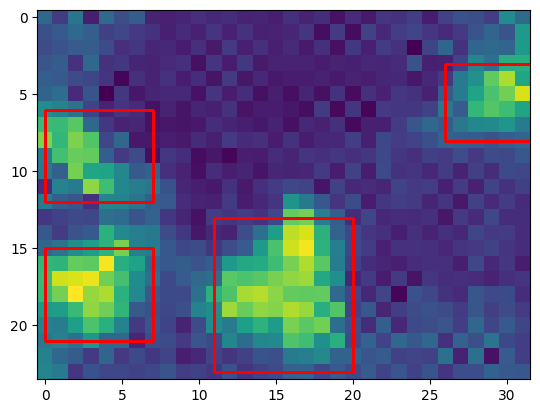

In [858]:
def decode_predictions(labels, anchors, box_variance=[0.1, 0.1, 0.2, 0.2]):
    decoded_boxes = []
    label_idx = 0
    for label in labels:
        # if label[4] == 1.0:
        #     print("label:", label)
        # elif label[4] == -1.0:
        #     print("label:", label)
        dx, dy, dw, dh = label[:4]
        anchor = anchors[label_idx]
        anchor_x, anchor_y, anchor_w, anchor_h = anchor
        cx = dx * box_variance[0] * anchor_w + anchor_x
        cy = dy * box_variance[1] * anchor_h + anchor_y
        width = np.exp(dw * box_variance[2]) * anchor_w
        height = np.exp(dh * box_variance[3]) * anchor_h
        x_min = cx - width / 2
        y_min = cy - height / 2
        decoded_box = [x_min, y_min, width, height]
        # print(np.array(decoded_box))
        if label[4] == 1.0:
            decoded_boxes.append(decoded_box)
        label_idx += 1
        # if len(np.array(decoded_boxes)) > 1: 
            # break
    print("Positive",len(np.array(decoded_boxes)))
    return decoded_boxes    
    # print(np.array(decoded_boxes))
    

# 바운딩 박스 그리기 함수
def draw_positive_bounding_boxes(image, decoded_boxes):
    plt.imshow(image)
    ax = plt.gca()
    # print(len(decoded_boxes))
    i = 0
    for box in decoded_boxes:
        i+=1
        # print(box)
        x_min, y_min, width, height = box
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    # print(i)
    plt.show()

# 앵커 박스 생성
anchor_box = AnchorBox()
anchors = anchor_box.get_anchors(24, 32)
# train_dataset에서 첫 번째 배치를 가져오고, 바운딩 박스 그리기
for batch in train_dataset.take(1):
    image = batch[0][0].numpy()
    labels = batch[1][0].numpy()  # 여기서 labels는 [오프셋x, 오프셋y, 스케일w, 스케일h, 클래스, 앵커 박스 인덱스]를 포함한다고 가정
    # print(labels)
    positive_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, 4], 1.0), tf.int32))
    negative_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, 4], -1.0), tf.int32))
    ignore_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, 4], -2.0), tf.int32))

    print("Positive 개수:", positive_count.numpy())
    print("Negative 개수:", negative_count.numpy())
    print("Ignore 개수:", ignore_count.numpy())

    # 오프셋 디코딩 및 바운딩 박스 그리기
    decoded_boxes = decode_predictions(labels, anchors)
    draw_positive_bounding_boxes(image, decoded_boxes)

In [859]:
class DepthwiseSeparableConv(layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = layers.DepthwiseConv2D(kernel_size=kernel_size, padding='same' if padding else 'valid', depth_multiplier=1, strides=stride, kernel_initializer=tf.keras.initializers.HeNormal())
        self.pointwise = layers.Conv2D(out_channels, kernel_size=1, strides=1, kernel_initializer=tf.keras.initializers.HeNormal())

    def call(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class DepthwiseConv(layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseConv, self).__init__()
        self.depthwise = DepthwiseSeparableConv(in_channels, out_channels, kernel_size, stride, padding)
        self.batch_norm = layers.BatchNormalization()
        self.silu = layers.Activation('silu')

    def call(self, x):
        out = self.depthwise(x)
        out = self.batch_norm(out)
        out = self.silu(out)
        return out

In [860]:
class Conv(layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(out_channels, kernel_size, strides=stride, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
        self.batch_norm = layers.BatchNormalization()
        self.silu = layers.Activation('silu')

    def call(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        return self.silu(x)

In [861]:
class Bottleneck(layers.Layer):
    def __init__(self, in_out_channels, mid_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv_0 = Conv(in_out_channels, mid_channels, kernel_size=1, stride=stride, padding=0)
        self.conv_1 = Conv(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1)
        self.conv_3 = Conv(mid_channels, in_out_channels, kernel_size=1, stride=stride, padding=0)

    def call(self, x):
        identity = x
        out = self.conv_0(x)
        out = self.conv_1(out)
        out = self.conv_3(out)
        out += identity
        return out

In [862]:
class CSPDenseLayer(layers.Layer):
    def __init__(self, in_out_channels, bottleneck_mid_channels, out_channels):
        super(CSPDenseLayer, self).__init__()
        self.conv_0 = Conv(in_out_channels // 2, in_out_channels, kernel_size=3, stride=1)
        self.conv_1 = Conv(in_out_channels // 2, in_out_channels, kernel_size=3, stride=1)
        self.bottleneck = Bottleneck(in_out_channels, bottleneck_mid_channels)
        self.conv_3 = Conv(in_out_channels * 2, out_channels, kernel_size=3, stride=1)

    def call(self, x):
        x1, x2 = tf.split(x, num_or_size_splits=2, axis=-1)
        x1 = self.conv_0(x1)
        x2 = self.conv_1(x2)
        out = self.bottleneck(x1)
        out = tf.concat([out, x2], axis=-1)
        out = self.conv_3(out)
        return out

In [863]:
class ChannelAttention(layers.Layer):
    def __init__(self, in_channels, reduction_ratio=16, pool_types=['avg', 'max'], kernel_size=3):
        super(ChannelAttention, self).__init__()
        self.pool_types = pool_types
        self.conv = layers.Conv2D(1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.HeNormal())
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        pooled_features = []
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                pooled = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
            elif pool_type == 'max':
                pooled = tf.reduce_max(x, axis=[1, 2], keepdims=True)
            pooled_features.append(pooled)
        
        concat = tf.concat(pooled_features, axis=-1)
        attention = self.conv(concat)
        attention = self.sigmoid(attention)
        return x * attention

In [864]:
class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=3):
        super(SpatialAttention, self).__init__()
        self.conv = layers.Conv2D(1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.HeNormal())
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        avg_out = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_out = tf.reduce_max(x, axis=-1, keepdims=True)
        x = tf.concat([avg_out, max_out], axis=-1)
        x = self.conv(x)
        return self.sigmoid(x)


In [865]:
class CBAM(layers.Layer):
    def __init__(self, in_channels, reduction_ratio=16, pool_types=['avg', 'max'], kernel_size=3):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio, pool_types, kernel_size)
        self.spatial_attention = SpatialAttention(kernel_size)

    def call(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x) * x
        return x

In [866]:
class SPPF(layers.Layer):
    def __init__(self, out_channels, kernel_size=3, stride=1, padding='SAME'):
        super(SPPF, self).__init__()
        self.conv = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, strides=stride, padding=padding, kernel_initializer=tf.keras.initializers.HeNormal())
        self.maxpool = layers.MaxPooling2D(pool_size=2, strides=1, padding='SAME')
        
    def call(self, inputs):
        x = self.conv(inputs)
        
        pool1 = self.maxpool(x)
        pool2 = self.maxpool(pool1)
        pool3 = self.maxpool(pool2)
        
        concatenated = tf.concat([x, pool1, pool2, pool3], axis=-1)
        return concatenated


In [867]:
class Upsample(layers.Layer):
    def __init__(self, size, interpolation = 'nearest'):
        super(Upsample, self).__init__()
        self.upsample = layers.UpSampling2D(size=size, interpolation = interpolation)

    def call(self, inputs):
        return self.upsample(inputs)


In [868]:
import tensorflow as tf
from tensorflow.keras import layers, models

class BackBone(tf.keras.layers.Layer):
    def __init__(self):
        super(BackBone, self).__init__()
        self.upsample = Upsample(size=(4, 4), interpolation='nearest')

        self.conv1 = Conv(in_channels=1, out_channels=4, kernel_size=6, stride=2, padding=2)
        
        self.conv2 = Conv(in_channels=4, out_channels=8, kernel_size=3, stride=2)
        self.csp1 = CSPDenseLayer(8, 4, 8)
        self.cbam1 = CBAM(8)
        
        self.conv3 = Conv(in_channels=8, out_channels=16, kernel_size=3, stride=2)
        self.csp2 = CSPDenseLayer(16, 8, 16)
        self.cbam2 = CBAM(16)
        
        self.conv4 = Conv(in_channels=16, out_channels=32, kernel_size=3, stride=2)
        self.csp3 = CSPDenseLayer(32, 16, 32)
        self.cbam3 = CBAM(32)
        self.sppf = SPPF(out_channels=32, kernel_size=3, stride=1)
        self.conv5 = Conv(in_channels = 32, out_channels = 32, kernel_size=3, stride=1)

        
    def call(self, inputs):
        x = self.upsample(inputs)
        x = self.conv1(x) # 12, 16
        x = self.conv2(x) # 24, 32
        p3 = self.csp1(x) # 24, 32
        p3 = self.cbam1(p3)

        x = self.conv3(p3) # 6, 8
        p4 = self.csp2(x)  # 12, 16
        p4 = self.cbam2(p4)

        x = self.conv4(p4) # 3, 4
        p5 = self.csp3(x)  
        p5 = self.cbam3(p5)
        p5 = self.sppf(p5)
        p5 = self.conv5(p5) # 6, 8
        
        return p3, p4, p5


In [869]:
class NeckLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(NeckLayer, self).__init__()
        self.conv_c10 = Conv(in_channels=32, out_channels=64, kernel_size=1, stride=1)
        self.upsample1 = layers.Conv2DTranspose(filters = 32, kernel_size = 1, strides=(2, 2), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
        self.csp = CSPDenseLayer(32, 16, 32)
        self.conv_c14 = Conv(in_channels=32, out_channels=64, kernel_size=1, stride=1)
        self.upsample2 = layers.Conv2DTranspose(filters = 32, kernel_size = 1, strides=(2, 2), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())

    def call(self, p3, p4, p5):
        c10 = self.conv_c10(p5) # 6, 8
        x = self.upsample1(c10) # 12, 16
        x = layers.concatenate([x, p4])
        x = self.csp(x) 
        c14 = self.conv_c14(x) 
        x = self.upsample2(c14) # 24, 32
        x = layers.concatenate([x, p3])
        return x, c14, c10
    
# • x=tf.Tensor(shape=(None, 48, 64, 16), dtype=float32)
# • c14=tf.Tensor(shape=(None, 24, 32, 25), dtype=float32)
# • c10=tf.Tensor(shape=(None, 12, 16, 128), dtype=float32)


In [870]:
class HeadLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(HeadLayer, self).__init__()
        self.csp_dense1 = CSPDenseLayer(64, 32, 64)
        self.conv1 = layers.Conv2D(64, 1, strides=2, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
        self.cbam1 = CBAM(64)
        self.csp_dense2 = CSPDenseLayer(64, 32, 64)
        self.conv2 = layers.Conv2D(64, 1, strides=2, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
        self.cbam2 = CBAM(64)
        self.csp_dense3 = CSPDenseLayer(64, 32, 64)

        self.channel_adjust1 = tf.keras.layers.Conv2D(64, 1, padding='same', use_bias=False) 
        self.channel_adjust2 = tf.keras.layers.Conv2D(64, 1, padding='same', use_bias=False) 
        self.channel_adjust3 = tf.keras.layers.Conv2D(64, 1, padding='same', use_bias=False) 
        
    def call(self, x, c14, c10):
        x = self.cbam1(x)
        out1 = self.csp_dense1(x)
        out1_adj = self.channel_adjust1(out1)
        x = self.conv1(out1)
        x = layers.concatenate([x, c14])
        x = self.cbam2(x)
        out2 = self.csp_dense2(x)
        out2_adj = self.channel_adjust2(out2)
        x = self.conv2(out2)
        x = layers.concatenate([x, c10])
        out3 = self.csp_dense3(x)
        out3_adj = self.channel_adjust3(out3)
        return out1_adj, out2_adj, out3_adj


In [871]:
class CustomModel(tf.keras.Model):
    def __init__(self, num_classes=1, num_anchors_per_location=9):
        super(CustomModel, self).__init__()
        self.backbone = BackBone()
        self.neck = NeckLayer()
        self.head = HeadLayer()
        self.backbone.trainable = True
        self.neck.trainable = True
        self.head.trainable = True

        self.prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))

        self.num_classes = num_classes

        # 각 위치(픽셀)에서 예측해야 하는 앵커 박스의 수
        self.num_anchors_per_location = num_anchors_per_location

        self.classification_conv1 = layers.Conv2D(128, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), bias_initializer = self.prior_probability)
        self.classification_conv2 = layers.Conv2D(128, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), bias_initializer = self.prior_probability)
     
        self.regression_conv1 = layers.Conv2D(128, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), bias_initializer = self.prior_probability)
        self.regression_conv2 = layers.Conv2D(128, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), bias_initializer = self.prior_probability)
    
    
        # 분류 헤드
        self.classification_head = tf.keras.Sequential([
            self.classification_conv1,
            self.classification_conv2,
            layers.Conv2D(self.num_anchors_per_location * num_classes, 3, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), bias_initializer = self.prior_probability)
        ])

        # 회귀 헤드
        self.regression_head = tf.keras.Sequential([
            self.regression_conv1,
            self.regression_conv2,
            layers.Conv2D(self.num_anchors_per_location * 4, 3, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), bias_initializer = self.prior_probability)
        ])

        self.classification_head.trainable = True
        self.regression_head.trainable = True
        
    def call(self, inputs):
        p3, p4, p5 = self.backbone(inputs)
        x, c14, c10 = self.neck(p3, p4, p5)
        out1, out2, out3 = self.head(x, c14, c10)

        cls_outputs = []
        reg_outputs = []
        N = tf.shape(inputs)[0]
        for feature in [out1, out2, out3]:
            # print(feature.shape)
            # 첫 번째 feature 맵 (None, 12, 16, 32)의 경우: 12x16 위치 각각에 9개의 앵커 박스 = 12x16x9 = 1728
            # 두 번째 feature 맵 (None, 6, 8, 32)의 경우: 6x8 위치 각각에 9개의 앵커 박스 = 6x8x9 = 432
            # 세 번째 feature 맵 (None, 3, 4, 32)의 경우: 3x4 위치 각각에 9개의 앵커 박스 = 3x4x9 = 108
            cls_output = self.classification_head(feature)
            reg_output = self.regression_head(feature)
            reg_output = tf.reshape(reg_output, [N, -1, 4])
            
            cls_output = tf.reshape(cls_output, [N, -1, self.num_classes])
            cls_outputs.append(cls_output)
            reg_outputs.append(reg_output)

        # 결과 결합
        reg_outputs = tf.concat(reg_outputs, axis=1)
        cls_outputs = tf.concat(cls_outputs, axis=1)
        # 최종 출력
        final_output = tf.concat([reg_outputs, cls_outputs], axis=-1)
        print(final_output.shape)
        return final_output


In [872]:
model = CustomModel(num_classes=1)
model.trainable = True
model.build(input_shape=(None, 24, 32, 1))
model.summary()

(None, None, 5)
Model: "custom_model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 back_bone_26 (BackBone)     multiple                  95882     
                                                                 
 neck_layer_26 (NeckLayer)   multiple                  45280     
                                                                 
 head_layer_26 (HeadLayer)   multiple                  460084    
                                                                 
 conv2d_1871 (Conv2D)        (None, None, None, 128)   8320      
                                                                 
 conv2d_1872 (Conv2D)        (None, None, None, 128)   16512     
                                                                 
 conv2d_1873 (Conv2D)        (None, None, None, 128)   8320      
                                                                 
 conv2d_1874 (Conv2D)        (None,

In [873]:
# class BoxLoss(tf.losses.Loss):  
#     def __init__(self, delta):
#         super(BoxLoss, self).__init__(
#             reduction="none", name="BoxLoss"
#         )
#         self._delta = delta

#     def call(self, y_true, y_pred):
#         difference = y_true - y_pred
#         absolute_difference = tf.abs(difference)
#         squared_difference = difference ** 2
#         loss = tf.where(
#             tf.less_equal(absolute_difference, self._delta),  # 여기를 수정
#             0.5 * squared_difference,
#             absolute_difference - 0.5
#         )

#         return tf.reduce_sum(loss, axis=-1)

In [874]:
# class ClassificationLoss(tf.losses.Loss):   
#     def __init__(self, alpha, gamma):
#         super(ClassificationLoss, self).__init__(
#             reduction="none", name="ClassificationLoss"
#         )
#         self._alpha = alpha
#         self._gamma = gamma

#     def call(self, y_true, y_pred):
#         cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
#             labels=y_true, logits=y_pred)
        
#         probs = tf.nn.sigmoid(y_pred)
#         alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
#         pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        
#         loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy

#         return tf.reduce_sum(loss, axis=-1)

In [875]:
# class Loss(tf.losses.Loss):    
#     def __init__(self, num_classes=1, alpha=0.75, gamma=2.0, delta=1.0):
#         super(Loss, self).__init__(reduction="auto", name="Loss")
#         self._cls_loss = ClassificationLoss(alpha, gamma)
#         self._box_loss = BoxLoss(delta)
#         self._num_classes = num_classes

#     def call(self, y_true, y_pred):
#         y_pred = tf.cast(y_pred, dtype=tf.float32)
#         print(y_pred.shape)
#         # 바운딩 박스 레이블과 예측값
#         box_labels = y_true[:, :, :4]
#         box_predictions = y_pred[:, :, :4]
#         # 클래스 레이블과 예측값
#         # cls_labels = tf.one_hot(
#         #     tf.cast(y_true[:, :, 4], dtype=tf.int32),
#         #     depth=self._num_classes,
#         #     dtype=tf.float32,
#         # )
#         # print(cls_labels)
#         cls_labels = y_true[:, :, 4:]
#         cls_predictions = y_pred[:, :, 4:]
#         # print(cls_predictions)
#         # cls_true = y_true[:, :, 4:]
#         # positive와 ignore 마스크
#         positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
#         ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)

#         cls_loss = self._cls_loss(cls_labels, cls_predictions)
#         box_loss = self._box_loss(box_labels, box_predictions)

#         # Positive 예시에 대한 추가 가중치 적용
#         # positive_weight_multiplier = 10.0
#         # cls_loss = tf.where(tf.equal(positive_mask, 1.0), cls_loss * positive_weight_multiplier, cls_loss)

#         # Ignore 예시에 대한 손실 0으로 설정
#         cls_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, cls_loss)
#         box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)

#         # 손실 정규화
#         normalizer = tf.reduce_sum(positive_mask, axis=-1)
#         cls_loss = tf.math.divide_no_nan(tf.reduce_sum(cls_loss, axis=-1), normalizer)
#         box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        
#         # 최종 손실 계산
#         loss = cls_loss + box_loss
#         return loss


In [876]:
class BoxLoss(tf.losses.Loss):
    def __init__(self, delta):
        super(BoxLoss, self).__init__(reduction="none", name="BoxLoss")
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.keras.backend.switch(
            tf.less_equal(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class ClassificationLoss(tf.losses.Loss):
    def __init__(self, alpha, gamma):
        super(ClassificationLoss, self).__init__(reduction="none", name="ClassificationLoss")
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.math.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class Loss(tf.losses.Loss):
    def __init__(self, num_classes=1, alpha=0.5, gamma=3.0, delta=2.0):
        super(Loss, self).__init__(reduction="auto", name="Loss")
        self._cls_loss = ClassificationLoss(alpha, gamma)
        self._box_loss = BoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]

        cls_labels = y_true[:, :, 4:]
        cls_predictions = y_pred[:, :, 4:]

        positive_mask = tf.cast(tf.math.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.math.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)

        cls_loss = self._cls_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)

        cls_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, cls_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)

        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        cls_loss = tf.math.divide_no_nan(tf.reduce_sum(cls_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)

        loss = cls_loss + box_loss
        return loss

In [877]:
# class BoxLoss(tf.losses.Loss):
#     def __init__(self, delta):
#         super(BoxLoss, self).__init__(reduction="none", name="BoxLoss")
#         self._delta = delta

#     def call(self, y_true, y_pred):
#         difference = y_true - y_pred
#         absolute_difference = tf.abs(difference)
#         squared_difference = difference ** 2
#         loss = tf.where(
#             tf.less(absolute_difference, self._delta),
#             0.5 * squared_difference,
#             absolute_difference - 0.5 * self._delta
#         )
#         return tf.reduce_sum(loss, axis=-1)

# class ClassificationLoss(tf.losses.Loss):
#     def __init__(self, alpha, gamma):
#         super(ClassificationLoss, self).__init__(reduction="none", name="ClassificationLoss")
#         self._alpha = alpha
#         self._gamma = gamma

#     def call(self, y_true, y_pred):
#         cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
#         probs = tf.nn.sigmoid(y_pred)
#         alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
#         pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
#         focal_loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
#         return tf.reduce_sum(focal_loss, axis=-1)

# class Loss(tf.losses.Loss):
#     def __init__(self, num_classes=1, alpha=0.25, gamma=2.0, delta=1.0):
#         super(Loss, self).__init__(reduction="auto", name="Loss")
#         self._cls_loss = ClassificationLoss(alpha, gamma)
#         self._box_loss = BoxLoss(delta)
#         self._num_classes = num_classes

#     def call(self, y_true, y_pred):
#         y_pred = tf.cast(y_pred, dtype=tf.float32)
#         box_labels = y_true[:, :, :4]
#         box_predictions = y_pred[:, :, :4]
#         cls_labels = y_true[:, :, 4:]
#         cls_predictions = y_pred[:, :, 4:]

#         positive_mask = tf.cast(tf.math.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
#         ignore_mask = tf.cast(tf.math.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)

#         cls_loss = self._cls_loss(cls_labels, cls_predictions)
#         box_loss = self._box_loss(box_labels, box_predictions)

#         cls_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, cls_loss)
#         box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)

#         normalizer = tf.reduce_sum(positive_mask, axis=-1)
#         cls_loss = tf.math.divide_no_nan(tf.reduce_sum(cls_loss, axis=-1), normalizer)
#         box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        
#         loss = cls_loss + box_loss
#         return loss

In [878]:
# import tensorflow as tf
# import numpy as np

# class MeanAveragePrecision(tf.keras.metrics.Metric):
#     def __init__(self, num_classes, anchors, iou_threshold=0.5, **kwargs):
#         super(MeanAveragePrecision, self).__init__(**kwargs)
#         self.num_classes = num_classes
#         self.anchors = anchors
#         self.iou_threshold = iou_threshold
#         self.true_positives = self.add_weight(name='tp', initializer='zeros', shape=(num_classes,))
#         self.false_positives = self.add_weight(name='fp', initializer='zeros', shape=(num_classes,))
#         self.false_negatives = self.add_weight(name='fn', initializer='zeros', shape=(num_classes,))

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.cast(y_pred, tf.float32)

#         for i in range(self.num_classes):
#             true_boxes = y_true[:, :, i * 4:(i + 1) * 4]
#             pred_offsets = y_pred[:, :, i * 4:(i + 1) * 4]
            
#             pred_boxes = self.decode_predictions(pred_offsets, self.anchors)

#             iou = self.calculate_iou(true_boxes, pred_boxes)
#             mask = tf.expand_dims(tf.greater_equal(iou, self.iou_threshold), -1)

#             true_positives = tf.reduce_sum(tf.cast(mask, tf.float32))
#             false_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(mask), tf.greater(pred_boxes, 0)), tf.float32))
#             false_negatives = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(mask), tf.greater(true_boxes, 0)), tf.float32))

#             self.true_positives.assign(tf.tensor_scatter_nd_add(self.true_positives, [[i]], [true_positives]))
#             self.false_positives.assign(tf.tensor_scatter_nd_add(self.false_positives, [[i]], [false_positives]))
#             self.false_negatives.assign(tf.tensor_scatter_nd_add(self.false_negatives, [[i]], [false_negatives]))


#     @tf.function
#     def decode_predictions(self, labels, anchors, box_variance=[0.1, 0.1, 0.2, 0.2]):
#         def decode_fn(labels, anchors):
#             decoded_boxes = []
#             label_idx = 0
#             for label in labels:
#                 dx, dy, dw, dh = label[:4]
#                 anchor = anchors[label_idx]
#                 anchor_x, anchor_y, anchor_w, anchor_h = anchor
#                 cx = dx * box_variance[0] * anchor_w + anchor_x
#                 cy = dy * box_variance[1] * anchor_h + anchor_y
#                 width = np.exp(dw * box_variance[2]) * anchor_w
#                 height = np.exp(dh * box_variance[3]) * anchor_h
#                 x_min = cx - width / 2
#                 y_min = cy - height / 2
#                 decoded_box = [x_min, y_min, width, height]
#                 if label[4] == 1.0:
#                     decoded_boxes.append(decoded_box)
#                 label_idx += 1
#             return np.array(decoded_boxes)
    
#         decoded_boxes = tf.numpy_function(decode_fn, [labels, anchors], tf.float32)
#         return decoded_boxes


#     def result(self):
#         precision = tf.math.divide_no_nan(self.true_positives, self.true_positives + self.false_positives)
#         recall = tf.math.divide_no_nan(self.true_positives, self.true_positives + self.false_negatives)
#         average_precision = tf.reduce_mean(precision)
#         return average_precision

#     def reset_state(self):
#         self.true_positives.assign(tf.zeros_like(self.true_positives))
#         self.false_positives.assign(tf.zeros_like(self.false_positives))
#         self.false_negatives.assign(tf.zeros_like(self.false_negatives))

#     def calculate_iou(self, true_boxes, pred_boxes):
#         true_boxes = tf.reshape(true_boxes, [-1, 4])
#         pred_boxes = tf.reshape(pred_boxes, [-1, 4])

#         x1 = tf.maximum(true_boxes[:, 0], pred_boxes[:, 0])
#         y1 = tf.maximum(true_boxes[:, 1], pred_boxes[:, 1])
#         x2 = tf.minimum(true_boxes[:, 2], pred_boxes[:, 2])
#         y2 = tf.minimum(true_boxes[:, 3], pred_boxes[:, 3])

#         intersection_area = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)
#         true_area = (true_boxes[:, 2] - true_boxes[:, 0]) * (true_boxes[:, 3] - true_boxes[:, 1])
#         pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
#         union_area = true_area + pred_area - intersection_area

#         iou = intersection_area / (union_area + tf.keras.backend.epsilon())
#         return iou


# class IntersectionOverUnion(tf.keras.metrics.Metric):
#     def __init__(self, num_classes, anchors, **kwargs):
#         super(IntersectionOverUnion, self).__init__(**kwargs)
#         self.num_classes = num_classes
#         self.anchors = anchors
#         self.intersection_over_union = self.add_weight(name='iou', initializer='zeros', shape=(num_classes,))

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.cast(y_pred, tf.float32)

#         for i in range(self.num_classes):
#             true_boxes = y_true[:, :, i * 4:(i + 1) * 4]
#             pred_offsets = y_pred[:, :, i * 4:(i + 1) * 4]
            
#             pred_boxes = self.decode_predictions(pred_offsets, self.anchors)

#             iou = self.calculate_iou(true_boxes, pred_boxes)
#             self.intersection_over_union[i].assign(tf.reduce_mean(iou))

#     def decode_predictions(self, labels, anchors, box_variance=[0.1, 0.1, 0.2, 0.2]):
#         labels = tf.reshape(labels, [-1, 5])  # labels의 모양을 (num_boxes, 5)로 변경
#         offsets = labels[:, :4]  # 오프셋 추출
#         class_labels = labels[:, 4:]  # 클래스 레이블 추출
    
#         anchor_x = anchors[:, 0]
#         anchor_y = anchors[:, 1]
#         anchor_w = anchors[:, 2]
#         anchor_h = anchors[:, 3]
    
#         cx = offsets[:, 0] * box_variance[0] * anchor_w + anchor_x
#         cy = offsets[:, 1] * box_variance[1] * anchor_h + anchor_y
#         width = tf.exp(offsets[:, 2] * box_variance[2]) * anchor_w
#         height = tf.exp(offsets[:, 3] * box_variance[3]) * anchor_h
    
#         x_min = cx - width / 2
#         y_min = cy - height / 2
    
#         decoded_boxes = tf.stack([x_min, y_min, width, height], axis=-1)
#         positive_mask = tf.cast(tf.equal(class_labels, 1.0), tf.bool)
#         decoded_boxes = tf.boolean_mask(decoded_boxes, positive_mask)
    
#         return decoded_boxes

#     def result(self):
#         return self.intersection_over_union

#     def reset_state(self):
#         self.intersection_over_union.assign(tf.zeros_like(self.intersection_over_union))

#     def calculate_iou(self, true_boxes, pred_boxes):
#         true_boxes = tf.reshape(true_boxes, [-1, 4])
#         pred_boxes = tf.reshape(pred_boxes, [-1, 4])

#         x1 = tf.maximum(true_boxes[:, 0], pred_boxes[:, 0])
#         y1 = tf.maximum(true_boxes[:, 1], pred_boxes[:, 1])
#         x2 = tf.minimum(true_boxes[:, 2], pred_boxes[:, 2])
#         y2 = tf.minimum(true_boxes[:, 3], pred_boxes[:, 3])

#         intersection_area = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)
#         true_area = (true_boxes[:, 2] - true_boxes[:, 0]) * (true_boxes[:, 3] - true_boxes[:, 1])
#         pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
#         union_area = true_area + pred_area - intersection_area

#         iou = intersection_area / (union_area + tf.keras.backend.epsilon())
#         return iou

In [879]:
initial_learning_rate = 0.0002
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

In [880]:
from keras.metrics import Precision, Recall

num_classes = 1

model = CustomModel(num_classes)
loss_fn = Loss(num_classes = 1)
optimizer = tf.optimizers.Adam(learning_rate = lr_schedule)

anchor_box = AnchorBox()
anchors = anchor_box.get_anchors(24, 32)

# map_metric = MeanAveragePrecision(num_classes=num_classes, anchors=anchors)
# iou_metric = IntersectionOverUnion(num_classes=num_classes, anchors=anchors)


# anchor_box = AnchorBox()
# anchors = anchor_box.get_anchors(24, 32)
# iou_metric = MultiBoxIoUMetric(anchors=anchors)
# 모델 컴파일
# model.compile(optimizer=optimizer, 
#               loss=[loss_fn],
#               metrics=['accuracy', iou_metric])

model.compile(optimizer=optimizer, 
              loss=[loss_fn])
            #   metrics=[''])

In [881]:
import tensorflow as tf

tf.config.run_functions_eagerly(False)

In [882]:
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Images max: {tf.reduce_max(images)}")
    print(f"Images min: {tf.reduce_min(images)}")
    # print("labels[:, :, :4]: ", labels[:, :, :4])
    print("Labels shape:", labels[:, :, :4].shape)

Images shape: (1, 24, 32, 1)
Labels shape: (1, 9072, 5)
Images max: 240.0
Images min: 0.0
Labels shape: (1, 9072, 4)


In [883]:
epochs = 5000

model.fit(
    # image, label,
    train_dataset,
    # batch_size= 12,
    epochs=epochs,
    # callbacks=callbacks_list,
    verbose=1,
)

Epoch 1/5000
(1, 9072, 5)
(1, 9072, 5)
1/1 [==============================] - 28s 28s/step - loss: 87.2200
Epoch 2/5000
1/1 [==============================] - 0s 87ms/step - loss: 68.6340
Epoch 3/5000
1/1 [==============================] - 0s 73ms/step - loss: 54.1528
Epoch 4/5000
1/1 [==============================] - 0s 79ms/step - loss: 40.9774
Epoch 5/5000
1/1 [==============================] - 0s 72ms/step - loss: 28.6203
Epoch 6/5000
1/1 [==============================] - 0s 73ms/step - loss: 20.4590
Epoch 7/5000
1/1 [==============================] - 0s 72ms/step - loss: 17.0185
Epoch 8/5000
1/1 [==============================] - 0s 67ms/step - loss: 14.7460
Epoch 9/5000
1/1 [==============================] - 0s 73ms/step - loss: 12.9316
Epoch 10/5000
1/1 [==============================] - 0s 75ms/step - loss: 11.0915
Epoch 11/5000
1/1 [==============================] - 0s 73ms/step - loss: 9.2001
Epoch 12/5000
1/1 [==============================] - 0s 67ms/step - loss: 7.6308
E

In [884]:
for img, label in train_dataset:
    # predictions = inference_model.predict(tf.expand_dims(img[0], axis=0))  # img에 첫 번째 차원을 추가
    predictions = model.predict(tf.expand_dims(img[0], axis=0))  # img에 첫 번째 차원을 추가
    print(predictions[0, :10, :])
    # positive_count = tf.reduce_sum(tf.cast(tf.equal(predictions[:, :, 4], 1.0), tf.int32))
    positive_count = tf.reduce_sum(tf.cast(tf.greater(predictions[:, :, 4], -1.0), tf.int32))
    # ignore_count = tf.reduce_sum(tf.cast(tf.less(predictions[:, :, 4], -2.0), tf.int32))

    print("Positive 개수:", positive_count.numpy())
    # print("Negative 개수:", negative_count.numpy())
    # print("Ignore 개수:", ignore_count.numpy())

(None, None, 5)
1/1 [==============================] - 1s 1s/step
[[ -0.6803808   -8.3982115    0.96725416   2.8611717   -0.8769736 ]
 [-11.868565   -12.965767     0.3022704    6.9695873   -0.6568551 ]
 [ -2.6078203  -11.063807    -4.2852316   -6.6737843   -0.94388056]
 [ -2.9071345   -7.544741    -4.2170796   -0.60212827  -2.3468065 ]
 [  1.5335331    0.948575     3.520073    -3.4460073   -5.7176547 ]
 [  1.2518573   -3.5674872   -0.30622435  -0.21000099  -6.799679  ]
 [  2.1374736   -1.9906821   -2.474282    -9.924725    -1.1144419 ]
 [  8.808115     3.637639    -6.9870763   -3.1963427   -0.3029604 ]
 [ 10.80969     -5.3380847   -1.3544164   -6.6338377   -1.199117  ]
 [ -7.309532    -8.996439     1.3352423    4.0286007   -1.0154147 ]]
Positive 개수: 5666


In [885]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import tensorflow as tf

# # decode_predictions 함수 정의
# def decode_predictions(labels, anchors, box_variance=[0.1, 0.1, 0.2, 0.2]):
#     decoded_boxes = []
#     for label_idx, label in enumerate(labels):
#         if label[4] > -1.0:  # 양성 레이블 조건 확인
#             dx, dy, dw, dh = label[:4]
#             anchor = anchors[label_idx]
#             anchor_x, anchor_y, anchor_w, anchor_h = anchor
#             cx = dx * box_variance[0] * anchor_w + anchor_x
#             cy = dy * box_variance[1] * anchor_h + anchor_y
#             width = np.exp(dw * box_variance[2]) * anchor_w
#             height = np.exp(dh * box_variance[3]) * anchor_h
#             x_min = cx - width / 2
#             y_min = cy - height / 2
#             decoded_box = [x_min, y_min, width, height]
#             decoded_boxes.append(decoded_box)
#     return decoded_boxes

# # draw_positive_bounding_boxes 함수 정의
# def draw_positive_bounding_boxes(image, decoded_boxes):
#     plt.imshow(image)
#     ax = plt.gca()
#     for box in decoded_boxes:
#         x_min, y_min, width, height = box
#         rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
#         ax.add_patch(rect)
#     plt.show()

# # 앵커 박스 및 디코딩 로직 사용 예시
# # 주의: AnchorBox 클래스의 구현과 train_dataset의 정의가 필요합니다.

# # 예를 들어, 앵커 박스 생성 및 train_dataset에서의 사용 예제는 다음과 같습니다:
# anchor_box = AnchorBox()
# anchors = anchor_box.get_anchors(24, 32)  # 앵커 박스 생성 예시, 실제 사용 시에는 해당 구현에 맞게 조정 필요

# for batch in train_dataset.take(1):
#     image = batch[0][0].numpy()
#     labels = batch[1][0].numpy()
#     decoded_boxes = decode_predictions(labels, anchors)
#     draw_positive_bounding_boxes(image, decoded_boxes)


1/1 [==============================] - 0s 36ms/step


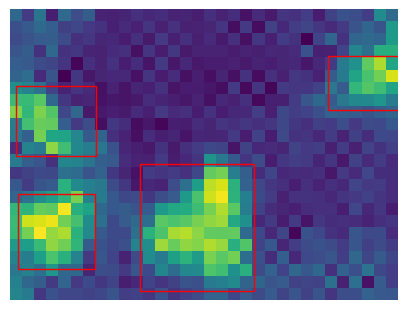

In [886]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

import numpy as np

def iou(box1, box2):
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2
    x_overlap = max(0, min(x2, x4) - max(x1, x3))
    y_overlap = max(0, min(y2, y4) - max(y1, y3))
    intersection = x_overlap * y_overlap
    area1 = (x2 - x1) * (y2 - y1)
    area2 = (x4 - x3) * (y4 - y3)
    union = area1 + area2 - intersection
    return intersection / union


def decode_predictions(predictions, anchors, box_variance=[0.1, 0.1, 0.2, 0.2], iou_threshold=0.5, score_threshold=0.5, top_n=4):
    decoded_boxes = []
    scores = []
    for i, prediction in enumerate(predictions):
        score = prediction[-1]
        if score > score_threshold:
            scores.append((score, i))

    # 점수에 따라 내림차순 정렬
    scores.sort(reverse=True)

    # 상위 N개 선택
    scores = scores[:top_n]

    # NMS 적용
    while scores:
        score, i = scores.pop(0)
        prediction = predictions[i]
        dx, dy, dw, dh = prediction[:4]
        anchor = anchors[i]
        anchor_x, anchor_y, anchor_w, anchor_h = anchor
        cx = dx * box_variance[0] * anchor_w + anchor_x
        cy = dy * box_variance[1] * anchor_h + anchor_y
        width = np.exp(dw * box_variance[2]) * anchor_w
        height = np.exp(dh * box_variance[3]) * anchor_h
        x_min = cx - width / 2
        y_min = cy - height / 2
        decoded_box = [x_min, y_min, x_min + width, y_min + height]
        decoded_boxes.append(decoded_box)

        # 선택된 박스와 높은 IoU를 가진 박스들 제거
        new_scores = []
        for score, j in scores:
            if iou(decoded_box, predictions[j][:4]) < iou_threshold:
                new_scores.append((score, j))
        scores = new_scores

    return decoded_boxes

def draw_bounding_boxes(image, boxes):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    ax = plt.gca()
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.axis('off')
    plt.show()

# AnchorBox 클래스와 get_anchors 함수가 필요합니다.

anchor_box = AnchorBox()
anchors = anchor_box.get_anchors(24, 32)  # 앵커 박스 생성 예시

for img, label in train_dataset:
    predictions = model.predict(tf.expand_dims(img[0], axis=0))[0]  # 첫 번째 이미지에 대한 예측 결과
    decoded_boxes = decode_predictions(predictions, anchors)  # 예측된 바운딩 박스 디코딩
    draw_bounding_boxes(img[0].numpy(), decoded_boxes)  # 디코딩된 바운딩 박스를 이미지에 그리기
